In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import matplotlib.colors as mcolors
import numpy as np
import collections
import seaborn as sns
from pygam import LogisticGAM
import matplotlib.tri as tri
from scipy.interpolate import griddata

In [2]:
data = pd.read_csv('pitch_data_2008_2021.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1,24,44,88,89,93) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
#grabbing columns we want
pitch_data = data[['pitch_name', 'plate_x', 'plate_z', 'description', 'stand', 'inning_topbot', "game_year"]]

#grabbing only umpire called pitches, no swings
pitch_data = pitch_data[pitch_data['description'].isin(['called_strike', 'ball', 'blocked_ball'])]

#blocked balls are just balls
pitch_data['description'].replace('blocked_ball', 'ball', inplace = True)

pitch_data.tail(10)

,pitch_name,plate_x,plate_z,description,stand,inning_topbot,game_year
519984,4-Seam Fastball,-0.12,3.78,ball,L,Top,2021
519985,4-Seam Fastball,0.13,3.49,ball,L,Top,2021
519988,4-Seam Fastball,0.07,1.68,called_strike,R,Bot,2021
519989,4-Seam Fastball,0.16,3.23,called_strike,L,Bot,2021
519992,4-Seam Fastball,-0.02,1.40,ball,R,Top,2021
519994,4-Seam Fastball,-1.10,1.94,ball,R,Bot,2021
519995,4-Seam Fastball,2.28,2.90,ball,R,Top,2021
519996,4-Seam Fastball,-0.39,1.39,ball,L,Top,2021
519997,Changeup,-0.28,-0.11,ball,R,Top,2021
519998,Changeup,0.73,2.27,called_strike,R,Bot,2021


In [13]:
pitch_data_fans = pitch_data[pitch_data["game_year"] < 2020]

In [14]:
pitch_data_fans.tail(5)

,pitch_name,plate_x,plate_z,description,stand,inning_topbot,game_year
479995,Slider,-1.27,2.95,ball,L,Top,2019
479996,4-Seam Fastball,1.09,2.81,ball,L,Bot,2019
479997,4-Seam Fastball,0.46,3.57,ball,L,Top,2019
479998,4-Seam Fastball,-0.96,0.94,ball,L,Top,2019
479999,4-Seam Fastball,1.19,1.96,ball,R,Bot,2019


In [15]:
pitch_data_fans_home = pitch_data_fans[pitch_data['inning_topbot'] == 'Bot']

<ipython-input-15-b165fad162e1>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pitch_data_fans_home = pitch_data_fans[pitch_data['inning_topbot'] == 'Bot']


In [16]:
pitch_data_fans_home.tail(5)

,pitch_name,plate_x,plate_z,description,stand,inning_topbot,game_year
479992,2-Seam Fastball,0.68,2.34,called_strike,R,Bot,2019
479993,Slider,0.04,2.19,called_strike,L,Bot,2019
479994,2-Seam Fastball,1.46,2.15,ball,R,Bot,2019
479996,4-Seam Fastball,1.09,2.81,ball,L,Bot,2019
479999,4-Seam Fastball,1.19,1.96,ball,R,Bot,2019


### Below are the distributions of pitches and their calls for home and away teams while fans are present

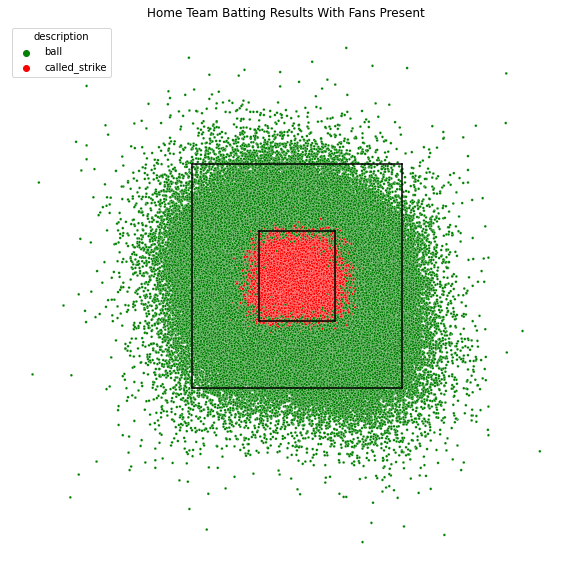

In [17]:
fig, ax = plt.subplots(figsize =(10,10))

# Outer Zone (To gage length from strikezone)

plt.plot([-2,-2],[0,5], color="black")     
plt.plot([2,2],[0,5], color="black")
plt.plot([-2,2],[0,0], color="black")
plt.plot([-2,2],[5,5], color="black")

#Strikezone

plt.plot([-.725,-.725],[1.5,3.5], color="black")  #left line
plt.plot([.725,.725],[1.5,3.5], color="black")   #right line
plt.plot([-.725,.725],[1.5,1.5], color="black")  #bottom line
plt.plot([-.725,.725],[3.5,3.5], color="black")  #top line

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

palette ={"ball": "green", "called_strike": "red"}    #differentiating balls and strikes

ax = sns.scatterplot(data=pitch_data_fans_home, x='plate_x', y='plate_z', hue = 'description', s = 7, palette = palette)
ax.set_title('Home Team Batting Results With Fans Present')

plt.show()

In [18]:
pitch_data_fans_away = pitch_data_fans[pitch_data['inning_topbot'] == 'Top']

<ipython-input-18-6df0d879ed6c>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pitch_data_fans_away = pitch_data_fans[pitch_data['inning_topbot'] == 'Top']


In [19]:
pitch_data_fans_away.tail(5)

,pitch_name,plate_x,plate_z,description,stand,inning_topbot,game_year
479986,Curveball,0.72,2.38,called_strike,R,Top,2019
479989,2-Seam Fastball,-0.33,1.83,called_strike,R,Top,2019
479995,Slider,-1.27,2.95,ball,L,Top,2019
479997,4-Seam Fastball,0.46,3.57,ball,L,Top,2019
479998,4-Seam Fastball,-0.96,0.94,ball,L,Top,2019


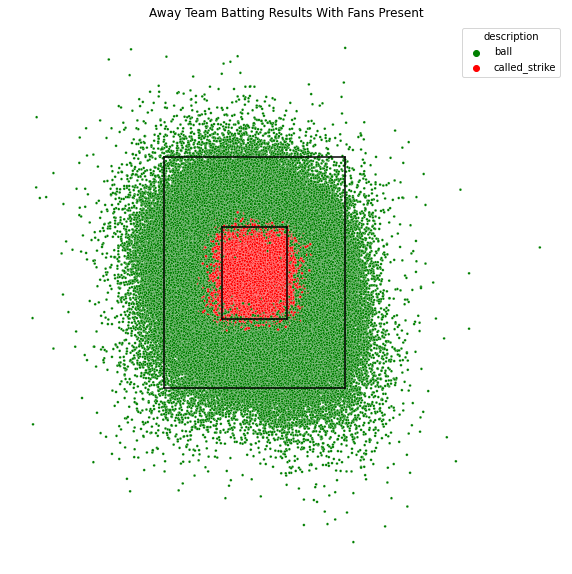

In [20]:
fig, ax = plt.subplots(figsize =(10,10))

# Outer Zone (To gage length from strikezone)

plt.plot([-2,-2],[0,5], color="black")     
plt.plot([2,2],[0,5], color="black")
plt.plot([-2,2],[0,0], color="black")
plt.plot([-2,2],[5,5], color="black")

#Strikezone

plt.plot([-.725,-.725],[1.5,3.5], color="black")  #left line
plt.plot([.725,.725],[1.5,3.5], color="black")   #right line
plt.plot([-.725,.725],[1.5,1.5], color="black")  #bottom line
plt.plot([-.725,.725],[3.5,3.5], color="black")  #top line

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

palette ={"ball": "green", "called_strike": "red"}    #differentiating balls and strikes

ax = sns.scatterplot(data=pitch_data_fans_away, x='plate_x', y='plate_z', hue = 'description', s = 7, palette = palette)
ax.set_title('Away Team Batting Results With Fans Present')

plt.show()

In [21]:
def create_combined_viz(data, title):
    pitch_data = data[['pitch_name', 'plate_x', 'plate_z', 'description', 'stand']]
    pitch_data = pitch_data[pitch_data['description'].isin(['called_strike', 'ball', 'blocked_ball'])]
    pitch_data['description'].replace('blocked_ball', 'ball', inplace = True)

    area_1_bounds = [-.725, -.241667, 2.833, 3.5]
    area_2_bounds = [-.241667, .241667, 2.833, 3.5]
    area_3_bounds = [.241667, .725, 2.833, 3.5]
    area_4_bounds = [-.725, -.241667, 2.166, 2.833]
    area_5_bounds = [-.241667, .241667, 2.166, 2.833]
    area_6_bounds = [.241667, .725, 2.166, 2.833]
    area_7_bounds = [-.725, -.241667, 1.5, 2.166]
    area_8_bounds = [-.241667, .241667, 1.5, 2.166]
    area_9_bounds = [.241667, .725, 1.5, 2.166]

    zones = [area_1_bounds, area_2_bounds, area_3_bounds, area_4_bounds, area_5_bounds, area_6_bounds, area_7_bounds, area_8_bounds, area_9_bounds]

    outside_rectangles = [[(-.9666,2.5), .24166, 1.333, (-.725, 3.5), .725, .333], [(.9666,2.5), -.24166, 1.333, (.725, 3.5), -.725, .333], [(-.9666,2.5), .24166, -1.333, (-.725, 1.5), .725, -.333], [(.9666,2.5), -.24166, -1.333, (.725, 1.5), -.725, -.333]]

    outside_1_bounds1 = [-.9666, -.725, 2.5, 3.833]
    outside_1_bounds2 = [-.725, 0, 3.5, 3.833]
    outside_2_bounds1 = [.725,.9666, 2.5, 3.833]
    outside_2_bounds2 = [.725, .9666, 3.5, 3.833]
    outside_3_bounds1 = [-.9666, -.725, 1.1666, 1.5]
    outside_3_bounds2 = [-.725, 0, 1.1666, 1.5]
    outside_4_bounds1 = [.725, .9666, 1.1666, 1.5]
    outside_4_bounds2 = [0, .725, 1.1666, 1.5]

    outside_zones = [(outside_1_bounds1, outside_1_bounds2), (outside_2_bounds1, outside_2_bounds2), (outside_3_bounds1, outside_3_bounds2), (outside_4_bounds1, outside_4_bounds2)]

    classifier_data = data[['description', 'plate_x', 'plate_z']]
    X = classifier_data[['plate_x', 'plate_z']]
    y = classifier_data['description']
    classifier_data['description'].replace('ball', 0, inplace = True)
    classifier_data['description'].replace('called_strike', 1, inplace = True)
    gam = LogisticGAM().fit(X, y)
    classifier_data['pred'] = gam.predict_mu(X)
    X = classifier_data['plate_x'].to_numpy()
    Y = classifier_data['plate_z'].to_numpy()
    Z = classifier_data['pred'].to_numpy()
    ngridx = 100
    ngridy = 150
    xi = np.linspace(-2, 2, ngridx)
    yi = np.linspace(.5, 4.5, ngridy)
    zi = griddata((X, Y), Z, (xi[None, :], yi[:, None]), method='linear')

    centers = []
    for zone in zones:
        zone_center = []
        zone_center.append(((zone[1] - zone[0])/2 + zone[0])-.175)
        zone_center.append((zone[3] - zone[2])/2 + zone[2]-.05)
        centers.append(zone_center)
    centers

    def grab_pitches_from_zone(data, zone_bounds):
        zone_data = data[data['plate_x'] > zone_bounds[0]]
        zone_data = zone_data[zone_data['plate_x'] < zone_bounds[1]]
        zone_data = zone_data[zone_data['plate_z'] > zone_bounds[2]]
        zone_data = zone_data[zone_data['plate_z'] < zone_bounds[3]]
        return zone_data
    def pct_correct_per_zone(data, zone_bounds):
        zone_data = grab_pitches_from_zone(data, zone_bounds)
        return (zone_data['description'].value_counts()['called_strike'] / zone_data['description'].size)*100
    def pct_correct_per_zone_outside(data, zone_bounds1, zone_bounds2):
        zone_data1 = grab_pitches_from_zone(data, zone_bounds1)
        zone_data2 = grab_pitches_from_zone(data, zone_bounds2)
        return ((zone_data1['description'].value_counts()['called_strike'] + zone_data2['description'].value_counts()['called_strike']) / (zone_data1['description'].size + zone_data2['description'].size))*100

    def inside_zone_list(data):
        inside_zone_list = []
        for zone in zones:
               inside_zone_list.append(pct_correct_per_zone(data, zone))
        return inside_zone_list
    def outside_zone_list(data):
        outside_zone_list = []
        for zone in range(len(outside_zones)):
            try:
                 outside_zone_list.append(pct_correct_per_zone_outside(data, outside_zones[zone][0], outside_zones[zone][1]))
            except:
                pass
        return  outside_zone_list

    def create_viz(data):
        cmap = plt.get_cmap('coolwarm')
        out_norm = mcolors.Normalize(vmin=0, vmax=50)
        outside_rectangles = [[(-.9666,2.5), .24166, 1.333, (-.725, 3.5), .725, .333], [(.9666,2.5), -.24166, 1.333, (.725, 3.5), -.725, .333], [(-.9666,2.5), .24166, -1.333, (-.725, 1.5), .725, -.333], [(.9666,2.5), -.24166, -1.333, (.725, 1.5), -.725, -.333]]
        cmap = plt.get_cmap('coolwarm')
        norm = mcolors.Normalize(vmin=60, vmax=100)
        rectangles = [(-.725,2.833), (-.241667,2.833), (.241667, 2.833), (-.725,2.166), (-.241667,2.166), (.241667, 2.166), (-.725,1.5), (-.241667,1.5), (.241667, 1.5)]

        fig, ax = plt.subplots(figsize =(10,10))


        plt.plot([-.725,-.725],[1.5,3.5], color="red")
        plt.plot([.725,.725],[1.5,3.5], color="red")
        plt.plot([-.725,.725],[1.5,1.5], color="red")
        plt.plot([-.725,.725],[3.5,3.5], color="red")


        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])

        for i, value in enumerate(inside_zone_list(data)): #inside data here
            rect = patch.Rectangle(rectangles[i], .4833, .6666, linewidth=1, edgecolor='black', facecolor=cmap(norm(value)), alpha = .5)
            ax.add_patch(rect)
        

        ax.contour(xi, yi, zi, levels= [.5, .9], linewidths= 2, colors=['black', 'blue'])
        ax.set_axisbelow(True)
        ax.yaxis.grid(color='gray', linestyle='dashed', alpha = .5)
        ax.xaxis.grid(color='gray', linestyle='dashed', alpha = .5)

        ax.set_title(title)

        plt.show()
    return create_viz(data)

### Here we can see the combined visualizations when fans are present

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-21-d709c8737c1d>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classifier_data['pred'] = gam.predict_mu(X)


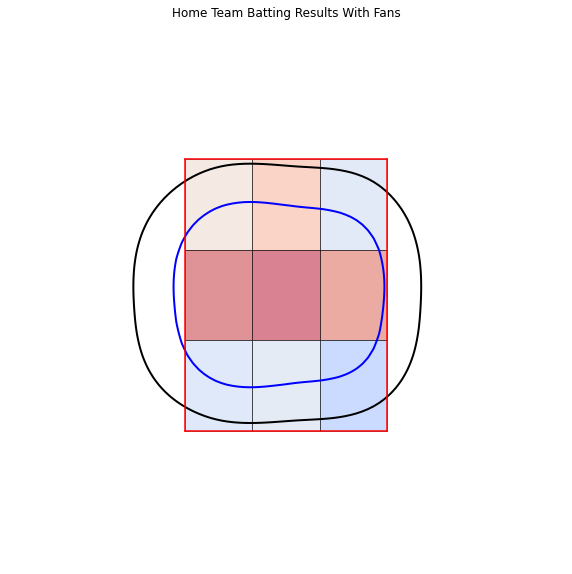

In [22]:
create_combined_viz(pitch_data_fans_home, "Home Team Batting Results With Fans")

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-21-d709c8737c1d>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classifier_data['pred'] = gam.predict_mu(X)


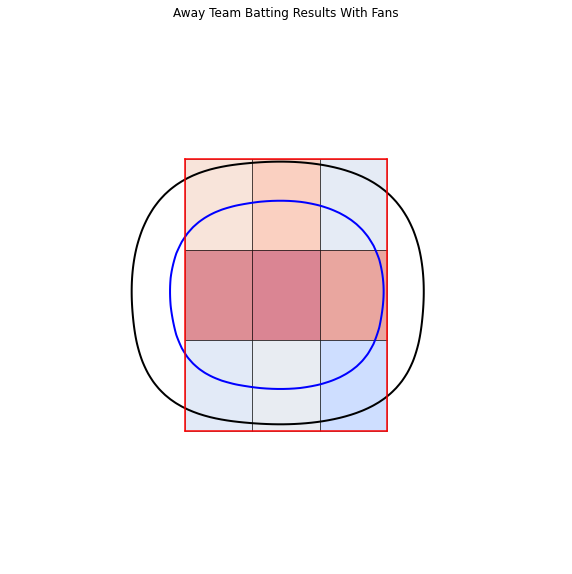

In [23]:
create_combined_viz(pitch_data_fans_away, "Away Team Batting Results With Fans")

### Here we can see the Call percentages based on the area of the strike zone with fans present

In [24]:
area_1_bounds = [-.725, -.241667, 2.833, 3.5]
area_2_bounds = [-.241667, .241667, 2.833, 3.5]
area_3_bounds = [.241667, .725, 2.833, 3.5]
area_4_bounds = [-.725, -.241667, 2.166, 2.833]
area_5_bounds = [-.241667, .241667, 2.166, 2.833]
area_6_bounds = [.241667, .725, 2.166, 2.833]
area_7_bounds = [-.725, -.241667, 1.5, 2.166]
area_8_bounds = [-.241667, .241667, 1.5, 2.166]
area_9_bounds = [.241667, .725, 1.5, 2.166]

zones = [area_1_bounds, area_2_bounds, area_3_bounds, area_4_bounds, area_5_bounds, area_6_bounds, area_7_bounds, area_8_bounds, area_9_bounds]

outside_rectangles = [[(-.9666,2.5), .24166, 1.333, (-.725, 3.5), .725, .333], [(.9666,2.5), -.24166, 1.333, (.725, 3.5), -.725, .333], [(-.9666,2.5), .24166, -1.333, (-.725, 1.5), .725, -.333], [(.9666,2.5), -.24166, -1.333, (.725, 1.5), -.725, -.333]]

outside_1_bounds1 = [-.9666, -.725, 2.5, 3.833]
outside_1_bounds2 = [-.725, 0, 3.5, 3.833]
outside_2_bounds1 = [.725,.9666, 2.5, 3.833]
outside_2_bounds2 = [.725, .9666, 3.5, 3.833]
outside_3_bounds1 = [-.9666, -.725, 1.1666, 1.5]
outside_3_bounds2 = [-.725, 0, 1.1666, 1.5]
outside_4_bounds1 = [.725, .9666, 1.1666, 1.5]
outside_4_bounds2 = [0, .725, 1.1666, 1.5]

outside_zones = [(outside_1_bounds1, outside_1_bounds2), (outside_2_bounds1, outside_2_bounds2), (outside_3_bounds1, outside_3_bounds2), (outside_4_bounds1, outside_4_bounds2)]

In [25]:
centers = []
for zone in zones:
    zone_center = []
    zone_center.append(((zone[1] - zone[0])/2 + zone[0])-.175)
    zone_center.append((zone[3] - zone[2])/2 + zone[2]-.05)
    centers.append(zone_center)
centers

[[-0.6583334999999999, 3.1165000000000003],
 [-0.175, 3.1165000000000003],
 [0.3083335, 3.1165000000000003],
 [-0.6583334999999999, 2.4495000000000005],
 [-0.175, 2.4495000000000005],
 [0.3083335, 2.4495000000000005],
 [-0.6583334999999999, 1.783],
 [-0.175, 1.783],
 [0.3083335, 1.783]]

In [26]:
def grab_pitches_from_zone(data, zone_bounds):
    zone_data = data[data['plate_x'] > zone_bounds[0]]
    zone_data = zone_data[zone_data['plate_x'] < zone_bounds[1]]
    zone_data = zone_data[zone_data['plate_z'] > zone_bounds[2]]
    zone_data = zone_data[zone_data['plate_z'] < zone_bounds[3]]
    return zone_data
def pct_correct_per_zone(data, zone_bounds):
    zone_data = grab_pitches_from_zone(data, zone_bounds)
    return (zone_data['description'].value_counts()['called_strike'] / zone_data['description'].size)*100
def pct_correct_per_zone_outside(data, zone_bounds1, zone_bounds2):
    zone_data1 = grab_pitches_from_zone(data, zone_bounds1)
    zone_data2 = grab_pitches_from_zone(data, zone_bounds2)
    return ((zone_data1['description'].value_counts()['called_strike'] + zone_data2['description'].value_counts()['called_strike']) / (zone_data1['description'].size + zone_data2['description'].size))*100

In [27]:
def inside_zone_list(data):
    inside_zone_list = []
    for zone in zones:
           inside_zone_list.append(pct_correct_per_zone(data, zone))
    return inside_zone_list
def outside_zone_list(data):
    outside_zone_list = []
    for zone in range(len(outside_zones)):
        try:
             outside_zone_list.append(pct_correct_per_zone_outside(data, outside_zones[zone][0], outside_zones[zone][1]))
        except:
            pass
    return  outside_zone_list

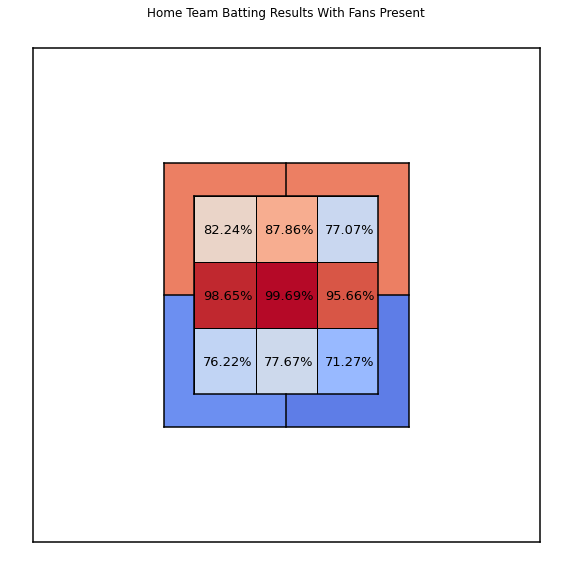

In [28]:
cmap = plt.get_cmap('coolwarm')
out_norm = mcolors.Normalize(vmin=0, vmax=50)
outside_rectangles = [[(-.9666,2.5), .24166, 1.333, (-.725, 3.5), .725, .333], [(.9666,2.5), -.24166, 1.333, (.725, 3.5), -.725, .333], [(-.9666,2.5), .24166, -1.333, (-.725, 1.5), .725, -.333], [(.9666,2.5), -.24166, -1.333, (.725, 1.5), -.725, -.333]]
cmap = plt.get_cmap('coolwarm')
norm = mcolors.Normalize(vmin=60, vmax=100)
rectangles = [(-.725,2.833), (-.241667,2.833), (.241667, 2.833), (-.725,2.166), (-.241667,2.166), (.241667, 2.166), (-.725,1.5), (-.241667,1.5), (.241667, 1.5)]

fig, ax = plt.subplots(figsize =(10,10))

plt.plot([-2,-2],[0,5], color="black")
plt.plot([2,2],[0,5], color="black")
plt.plot([-2,2],[0,0], color="black")
plt.plot([-2,2],[5,5], color="black")

plt.plot([-.725,-.725],[1.5,3.5], color="black")
plt.plot([.725,.725],[1.5,3.5], color="black")
plt.plot([-.725,.725],[1.5,1.5], color="black")
plt.plot([-.725,.725],[3.5,3.5], color="black")

plt.plot([-.9666,-.9666],[1.1666,3.833], color="black")
plt.plot([.9666,.9666],[1.1666,3.833], color="black")
plt.plot([-.9666,.9666],[1.166,1.166], color="black")
plt.plot([-.9666,.9666],[3.833,3.833], color="black")

plt.plot([0,0],[3.5,3.833], color="black")
plt.plot([0,0],[1.16666,1.5], color="black")
plt.plot([-.9666,-.725],[2.5,2.5], color="black")
plt.plot([.725,.9666],[2.5,2.5], color="black")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

for i, value in enumerate(inside_zone_list(pitch_data_fans_home)): #inside data here
    rect = patch.Rectangle(rectangles[i], .4833, .6666, linewidth=1, edgecolor='black', facecolor=cmap(norm(value)))
    ax.add_patch(rect)
    ax.text(centers[i][0], centers[i][1], '{:.2f}%'.format(inside_zone_list(pitch_data_fans_home)[i]), fontsize = 13)

for i, value in enumerate(outside_zone_list(pitch_data_fans_home)): #outside_data_here
    rect1 =  patch.Rectangle(outside_rectangles[i][0], outside_rectangles[i][1], outside_rectangles[i][2], linewidth=0, edgecolor='black', facecolor=cmap(out_norm(value)))
    rect2 = patch.Rectangle(outside_rectangles[i][3], outside_rectangles[i][4], outside_rectangles[i][5], linewidth=0, edgecolor='black', facecolor=cmap(out_norm(value)))
    ax.add_patch(rect1)
    ax.add_patch(rect2)

ax.set_title("Home Team Batting Results With Fans Present")

plt.show()

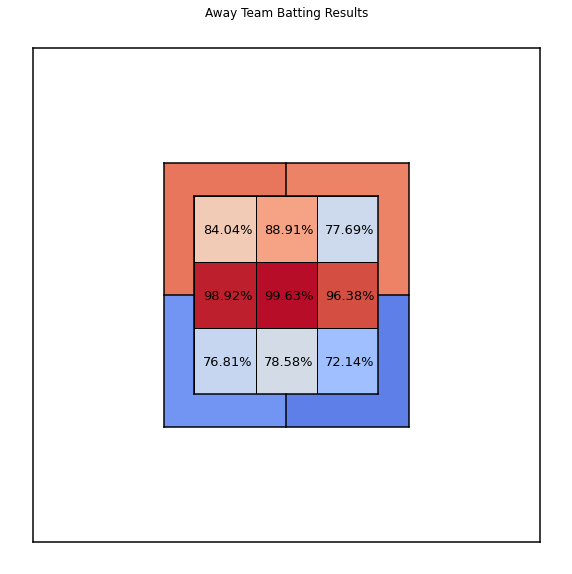

In [29]:
cmap = plt.get_cmap('coolwarm')
out_norm = mcolors.Normalize(vmin=0, vmax=50)
outside_rectangles = [[(-.9666,2.5), .24166, 1.333, (-.725, 3.5), .725, .333], [(.9666,2.5), -.24166, 1.333, (.725, 3.5), -.725, .333], [(-.9666,2.5), .24166, -1.333, (-.725, 1.5), .725, -.333], [(.9666,2.5), -.24166, -1.333, (.725, 1.5), -.725, -.333]]
cmap = plt.get_cmap('coolwarm')
norm = mcolors.Normalize(vmin=60, vmax=100)
rectangles = [(-.725,2.833), (-.241667,2.833), (.241667, 2.833), (-.725,2.166), (-.241667,2.166), (.241667, 2.166), (-.725,1.5), (-.241667,1.5), (.241667, 1.5)]

fig, ax = plt.subplots(figsize =(10,10))

plt.plot([-2,-2],[0,5], color="black")
plt.plot([2,2],[0,5], color="black")
plt.plot([-2,2],[0,0], color="black")
plt.plot([-2,2],[5,5], color="black")

plt.plot([-.725,-.725],[1.5,3.5], color="black")
plt.plot([.725,.725],[1.5,3.5], color="black")
plt.plot([-.725,.725],[1.5,1.5], color="black")
plt.plot([-.725,.725],[3.5,3.5], color="black")

plt.plot([-.9666,-.9666],[1.1666,3.833], color="black")
plt.plot([.9666,.9666],[1.1666,3.833], color="black")
plt.plot([-.9666,.9666],[1.166,1.166], color="black")
plt.plot([-.9666,.9666],[3.833,3.833], color="black")

plt.plot([0,0],[3.5,3.833], color="black")
plt.plot([0,0],[1.16666,1.5], color="black")
plt.plot([-.9666,-.725],[2.5,2.5], color="black")
plt.plot([.725,.9666],[2.5,2.5], color="black")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

for i, value in enumerate(inside_zone_list(pitch_data_fans_away)): #inside data here
    rect = patch.Rectangle(rectangles[i], .4833, .6666, linewidth=1, edgecolor='black', facecolor=cmap(norm(value)))
    ax.add_patch(rect)
    ax.text(centers[i][0], centers[i][1], '{:.2f}%'.format(inside_zone_list(pitch_data_fans_away)[i]), fontsize = 13)

for i, value in enumerate(outside_zone_list(pitch_data_fans_away)): #outside_data_here
    rect1 =  patch.Rectangle(outside_rectangles[i][0], outside_rectangles[i][1], outside_rectangles[i][2], linewidth=0, edgecolor='black', facecolor=cmap(out_norm(value)))
    rect2 = patch.Rectangle(outside_rectangles[i][3], outside_rectangles[i][4], outside_rectangles[i][5], linewidth=0, edgecolor='black', facecolor=cmap(out_norm(value)))
    ax.add_patch(rect1)
    ax.add_patch(rect2)

ax.set_title("Away Team Batting Results")

plt.show()